# Nomad TCO Kaggle Competition
Goal: Predict band gap and formation energies using only basic geometric and atomic information from unit cell of transparent conducting oxides <br />
Code: 1) Loads geometries, 2) Engineers features from base data, 3) Tests multiple predictive models using sklearn
Best Yet: Light Gradient Boosting (lgb) using base features and bond length/coordination information

Next Steps: lgb with cross validation, add features from PCA of atomic positions.

In [1]:
import os
import numpy as np 
import pandas as pd 

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly import tools

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull

import sklearn.metrics as metrics
from sklearn.metrics.scorer import make_scorer

from sklearn.linear_model import LinearRegression

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
import itertools
from scipy import linalg

from sklearn.svm import SVR

from sklearn.multioutput import MultiOutputRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier

import networkx as nx

init_notebook_mode(connected=True)

In [2]:
print(os.getcwd())

C:\Users\Jonathan\Documents\Python Scripts\Kaggle\Nomad - TCO


# Scoring Functions

In [3]:
def mean_squared_log_error_JT(ground_truth, predictions):
    diff = np.power((np.log(predictions+1) - np.log(ground_truth+1)),2)
    return np.sqrt(np.average(diff))

## Load Data

In [35]:
dfTrain = pd.read_csv("data/train.csv")
dfTest = pd.read_csv("data/test.csv")
smplSub = pd.read_csv("sample_submission.csv")
assert(all(dfTrain.isnull().sum()) == False) # report if any missing data
assert(all(dfTest.isnull().sum()) == False) # report if any missing data

In [36]:
dfTrain.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,80,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


## Feature Creation Functions

In [37]:
def LoadGeometries(folderPath):
    '''
    Function to read in geometry of each material, calculistLate necessary properties, and merge with original df to use as features
    Depends on following functions: LoadGeometry
    Inputs:
    1) folderPath: path to folder containing all subfolders for each geometry (1,2, etc.)
    '''
    dfToMerge = pd.DataFrame()
    
    folders = os.listdir(folderPath)
    for folder in folders:
        tmpMat = CalcGeometryFeatures(folderPath, folder)
        dfToMerge = dfToMerge.append(tmpMat)
    
    return dfToMerge

In [38]:
def LoadGeomPCAFeatures(folderPath):
    '''
    Function to read in geometry of each material, calculate PCA features, and create df that can be merged later
    with other feature df (e.g. LoadGeometries df)
    Depends on following functions: GeometryPCA
    Inputs:
    1) folderPath: path to folder containing all subfolders for each geometry (1,2, etc.)
    '''
    dfToMerge = pd.DataFrame()
    
    folders = os.listdir(folderPath)
    for folder in folders:
        tmpMat = GeometryPCA(folderPath, folder, plotFlag=False)
        dfToMerge = dfToMerge.append(tmpMat)
    
    return dfToMerge

In [39]:
def GeometryPCA(folderPath, folder, plotFlag=False):
    '''
    Reads one geometry and calculates PCA transformation and plots 2d comparisons of axes
    Returns PCA coordinates
    Inputs:
    1) folderPath: path to folder containing all subfolders for each geometry (1,2, etc.)
    2) folder: folder for individual geometry with geometry.xyz file
    3) plotFlag: if True, plots the PCA results for that geometry
    '''
    with open(folderPath + "/" + folder + "/geometry.xyz") as f:
        colAtom = ['atom', 'x', 'y', 'z'] # column names for atom-level df
        dfAtom = pd.DataFrame(columns = colAtom) # atom-level df
        
        colMatFeat = ['id']
        dfMat = pd.DataFrame(columns = colMatFeat, index = [0]) # material-level df
        if 'id' in colMatFeat:
            dfMat['id'] = folder # add id to df for merging later with original df
        
        lat = [] # tmp list for listLattice vector info
        for line in f.readlines(): # read geometry of material and put all atom and listLattice info into dfs
            split = line.split()
            if split[0] == "lattice_vector":
                latVectors = split[1:4]
                latVectors = [float(x) for x in latVectors]
                lat.append(latVectors) # store lattice vectors as floats
            if split[0] == "atom":
                data = split[1:5] # store atom positions
                dfAtom = dfAtom.append(pd.DataFrame([[data[3], float(data[0]),
                                                      float(data[1]), float(data[2])]],
                                                    columns = colAtom),
                                       ignore_index=True)
    
    #Plot PCA analysis of coordinates
    pca, volume = PCAplot(dfAtom, plotFlag)

    #Feature: Add volume to feature list
    dfMat['Hull Volume'] = volume[0]
    dfMat['Hull Volume 1-2'] = volume[1]
    dfMat['Hull Volume 1-3'] = volume[2]
    dfMat['Hull Volume 2-3'] = volume[3]
    dfMat['Hull Volume Per Atom'] = volume[0] / len(dfAtom)
    dfMat['Hull Volume 1-2 Per Atom'] = volume[1] / len(dfAtom)
    dfMat['Hull Volume 1-3 Per Atom'] = volume[2] / len(dfAtom)
    dfMat['Hull Volume 2-3 Per Atom'] = volume[3] / len(dfAtom)
    
    #Feature: Count number of unique coordinate values along each PCA axis
    dfMat['Unique 1'] = len(set(np.round(pca,2)['1st']))
    dfMat['Unique 2'] = len(set(np.round(pca,2)['2nd']))
    dfMat['Unique 3'] = len(set(np.round(pca,2)['3rd']))
    
    #Feature: Calculate cluster features
    dfMat = CalcPCAClusterFeatures(dfMat, pca, ['1st', '2nd', '3rd'])
    
    return dfMat

In [40]:
def CalcPCAClusterFeatures(inDfMat, inDfPCA, colPCA):
    '''
    Calculates multiple features from PCA data using PCA coordinate matrix as input
    Use GMM to find cluster number with full covariance for elongated shapes.
    Input:
    1) inDfMat: df with calculated material properties that will be appended to final features list
    2) inDfPCA: df with 3 PCA directions (1st, 2nd, 3rd column names)
    3) colPCA: list of column names on which to perform PCA
    '''

    #Count number of clusters and clusters per atom in 3D
    bic3D = []
    for k in range(1,len(inDfPCA)):
        gmm = GaussianMixture(n_components = k, covariance_type = 'full',
                              init_params = 'kmeans', max_iter=300)
        gmm.fit(inDfPCA)
        gmm.predict(inDfPCA)
        bic3D.append(gmm.bic(inDfPCA))
    inDfMat['Clusters'] = np.argmin(bic3D)
    inDfMat['Clusters Per Atom'] = np.argmin(bic3D) / len(inDfPCA)
    
    #Count number of clusters and clusters per atom in each PCA direction
    listCluster = []
    for i in range(0,2):
        for j in range(i+1,3):
            dfInput = inDfPCA[[colPCA[i], colPCA[j]]] #set to current 2 PCA coordinate lists
            bic = [] #initialize list of bic scores
            
            #GMM loop over cluster number to find minimal bic score
            for k in range(1,len(dfInput)):
                gmm = GaussianMixture(n_components = k, covariance_type = 'full',
                                      init_params = 'kmeans', max_iter=300)
                gmm.fit(dfInput)
                gmm.predict(dfInput)
                bic.append(gmm.bic(dfInput))
            
            #Append cluster number with minium bic score, then do final GMM with that number
            #--CAN USE LATER FOR COVARIANCES AS FEATURES!
            listCluster.append(np.argmin(bic)+1)
            gmmFinal = GaussianMixture(n_components = (np.argmin(bic)+1), covariance_type = 'full',
                                      init_params = 'kmeans', max_iter=300)
            gmmFinal.fit(dfInput)
    
    inDfMat['Clusters 1-2'] = listCluster[0]
    inDfMat['Clusters 1-3'] = listCluster[1]
    inDfMat['Clusters 2-3'] = listCluster[2]
    inDfMat['Clusters 1-2 Per Atom'] = listCluster[0] / len(dfInput)
    inDfMat['Clusters 1-3 Per Atom'] = listCluster[1] / len(dfInput)
    inDfMat['Clusters 2-3 Per Atom'] = listCluster[2] / len(dfInput)
    
    return inDfMat

In [41]:
def plot_results(X, Y_, means, covariances, index, title):
    '''
    Function plots results of GMM clusteirng performed in CalcPCAClusterFeatures
    '''
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

#USAGE EXAMPLE
#X = np.asfarray(dfInput)
#gm = GaussianMixture(n_components = 11, covariance_type = 'full', max_iter=300)
#gm.fit(X)
#color_iter = itertools.cycle(['navy', 'blue', 'cornflowerblue', 'gold',
#                              'darkorange', 'orange'])
#plot_results(X, gm.predict(X), gm.means_, gm.covariances_, 1,
#             'GM')

In [42]:
def PCAplot(geom, plotFlag=False):
    '''
    Calculates PCA transformation of one geometry and returns coordinates and hull volumes
    Inputs:
    1) geom: dataframe with geometry for individual material
    '''
    #save coordinates and atomType (used for color)
    coord = geom[['x', 'y', 'z']]
    atomType = [str(i) for i in geom['atom']]
    dictColor = {'Al':'green', 'Ga':'red', 'In':'blue', 'O':'black'}
    
    #PCA transformation into matrix output for plotting
    coordPCA = PCA(n_components = 3).fit(coord).transform(coord)
    dfPCA = pd.DataFrame(coordPCA, columns = ['1st', '2nd', '3rd'])
    
    #Calculate values associated with PCA
    #Hull values
    h123 = ConvexHull(dfPCA.iloc[:][['1st', '2nd', '3rd']])
    vol123 = h123.volume
    h12 = ConvexHull(dfPCA.iloc[:][['1st', '2nd']])
    vol12 = h12.volume
    h13 = ConvexHull(dfPCA.iloc[:][['1st', '3rd']])
    vol13 = h13.volume
    h23 = ConvexHull(dfPCA.iloc[:][['2nd', '3rd']])
    vol23 = h23.volume
    
    #Plot coordinates with colored atoms and 1st 2 dimensions of PCA
    if plotFlag==True:
        fig = plt.figure(figsize=(15,15))
        ax1 = fig.add_subplot(221, projection='3d')
        ax1.scatter(coord[['x']], coord[['y']], coord[['z']], color = [dictColor[i] for i in atomType], alpha = 0.7)
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')
        
        ax2 = fig.add_subplot(222)
        ax2.scatter(dfPCA.iloc[:]['1st'], dfPCA.iloc[:]['2nd'], color = [dictColor[i] for i in atomType], alpha = 0.7)
        ax2.plot(dfPCA.loc[h12.vertices]['1st'], dfPCA.loc[h12.vertices]['2nd'], 'r-', lw=1)
        ax2.set_xlabel('1st component')
        ax2.set_ylabel('2nd component')

        ax3 = fig.add_subplot(223)
        ax3.scatter(dfPCA.iloc[:]['1st'], dfPCA.iloc[:]['3rd'], color = [dictColor[i] for i in atomType], alpha = 0.7)
        ax3.plot(dfPCA.loc[h13.vertices]['1st'], dfPCA.loc[h13.vertices]['3rd'], 'r-', lw=1)
        ax3.set_xlabel('1st component')
        ax3.set_ylabel('3rd component')

        ax4 = fig.add_subplot(224)
        ax4.scatter(dfPCA.iloc[:]['2nd'], dfPCA.iloc[:]['3rd'], color = [dictColor[i] for i in atomType], alpha = 0.7)
        ax4.plot(dfPCA.loc[h23.vertices]['2nd'], dfPCA.loc[h23.vertices]['3rd'], 'r-', lw=1)
        ax4.set_xlabel('2nd component')
        ax4.set_ylabel('3rd component')
    
    return dfPCA, [vol123, vol12, vol13, vol23]

In [43]:
def CalcGeometryFeatures(folderPath, folder):
    '''
    Reads one geometry and calculates all necessary features
    Inputs:
    1) folderPath: directoy with all subfolders for individual material geometries
    2) folder: folder with geometry.xyz file for one material
    '''
    with open(folderPath + "/" + folder + "/geometry.xyz") as f:
        colAtom = ['atom', 'x', 'y', 'z'] # column names for atom-level df
        dfAtom = pd.DataFrame(columns = colAtom) # atom-level df
        
        colMatFeat = ['id', 'xx', 'xy', 'xz', 'yx', 'yy', 'yz', 'zx', 'zy', 'zz']
        dfMat = pd.DataFrame(columns = colMatFeat, index = [0]) # material-level df
        if 'id' in colMatFeat:
            dfMat['id'] = folder # add id to df for merging later with original df
        
        lat = [] # tmp list for listLattice vector info
        for line in f.readlines(): # read geometry of material and put all atom and listLattice info into dfs
            split = line.split()
            if split[0] == "lattice_vector":
                latVectors = split[1:4]
                latVectors = [float(x) for x in latVectors]
                lat.append(latVectors) # store lattice vectors as floats
            if split[0] == "atom":
                data = split[1:5] # store atom positions
                dfAtom = dfAtom.append(pd.DataFrame([[data[3], float(data[0]),
                                                      float(data[1]), float(data[2])]],
                                                    columns = colAtom),
                                       ignore_index=True)
    
        # Save lattice vector information to dfMat
        dfMat = AddLattice(dfMat, colMatFeat, lat)
        
        #Calculate distances between all atoms using PBC's
        dfAtom = CalcDistances(dfAtom, lat, nndist1=1.2)
        
        # Bond lengths, NN distances, and coordination numbers
        #--For each atom type
        for atom in ['O', 'Ga', 'Al', 'In']:
            if len(dfAtom[dfAtom['atom'] == atom]) > 0:
                dfMat[atom + ' CN Avg'] = dfAtom.groupby('atom').mean().at[atom,'CN']
                dfMat[atom + ' CN Min'] = dfAtom.groupby('atom').min().at[atom,'CN']
                dfMat[atom + ' CN Max'] = dfAtom.groupby('atom').max().at[atom,'CN']
                dfMat[atom + '-O NN1 BL Avg'] = dfAtom.groupby('atom').mean().at[atom,'O NN1 BL']
                dfMat[atom + '-O NN1 BL Min'] = dfAtom.groupby('atom').min().at[atom,'O NN1 BL']
                dfMat[atom + '-O NN1 BL Max'] = dfAtom.groupby('atom').max().at[atom,'O NN1 BL']
                dfMat[atom + '-Ga NN1 BL Avg'] = dfAtom.groupby('atom').mean().at[atom,'Ga NN1 BL']
                dfMat[atom + '-Ga NN1 BL Min'] = dfAtom.groupby('atom').min().at[atom,'Ga NN1 BL']
                dfMat[atom + '-Ga NN1 BL Max'] = dfAtom.groupby('atom').max().at[atom,'Ga NN1 BL']
                dfMat[atom + '-Al NN1 BL Avg'] = dfAtom.groupby('atom').mean().at[atom,'Al NN1 BL']
                dfMat[atom + '-Al NN1 BL Min'] = dfAtom.groupby('atom').min().at[atom,'Al NN1 BL']
                dfMat[atom + '-Al NN1 BL Max'] = dfAtom.groupby('atom').max().at[atom,'Al NN1 BL']
                dfMat[atom + '-In NN1 BL Avg'] = dfAtom.groupby('atom').mean().at[atom,'In NN1 BL']
                dfMat[atom + '-In NN1 BL Min'] = dfAtom.groupby('atom').min().at[atom,'In NN1 BL']
                dfMat[atom + '-In NN1 BL Max'] = dfAtom.groupby('atom').max().at[atom,'In NN1 BL']
            
        # Bond angle
    
    return dfMat

In [44]:
def CalcDistances(df, lat, nndist1=1.2):
    '''
    1) Calculates bond lengths for 1st and 2nd nearest neighbors for each atom type
    2) Calculates coordination number of each atom
    Inputs:
    df: dataframe with atomic information for single material
    lat: lattice vectors
    nndist1: upper limit for 1st nearest neighbor distance (nndist1 times minimum distance between atoms)
    '''
    # Create columns:
    df['CN'] = np.nan #coordination number
    df['O NN1 BL'] = np.nan #average bond length of closest atom
    df['O NN1 Count'] = 0 #closest atom coordination number
    df['Ga NN1 BL'] = np.nan #average bond length of closest atom
    df['Ga NN1 Count'] = 0 #closest atom coordination number
    df['Al NN1 BL'] = np.nan #average bond length of closest atom
    df['Al NN1 Count'] = 0 #closest atom coordination number
    df['In NN1 BL'] = np.nan #average bond length of closest atom
    df['In NN1 Count'] = 0 #closest atom coordination number
    
    #Create reciprocal lattice vectors
    lat_r = np.linalg.inv(lat)
    
    # Cycle through each atom and calculate distance to all others
    for ind1 in df.index:
        tmpDist = [] #temporary list of distances
        tmpAtom = [] #temporary list of atom corresponding to each distance
        v1 = np.asfarray(df.iloc[ind1]['x':'z'])
        #v1_r = np.matmul(lat_r, v1) #represent v1 in recip. space
        # Loop over every other atom
        for ind2 in df.index:
            if ind1 != ind2:
                v2 = np.asfarray(df.iloc[ind2]['x':'z']) #other coordinates as np array
                #v2_r = np.matmul(lat_r, v2) #represent v2 in recip. space
                dist = DistancePBCreal(v1, v2, lat)
                tmpDist.append(dist) #distance list for one atom
                tmpAtom.append(df.at[ind2, 'atom']) #atoms at each distance
        tmpDf = pd.DataFrame(columns=['distance', 'atom'])
        tmpDf['distance'] = tmpDist
        tmpDf['atom'] = tmpAtom
        tmpDf = tmpDf.sort_values(by = ['distance'])
        
        #Calculate coordination number
        tmpCN = tmpDf[(tmpDf['distance'] >= min(tmpDf['distance'])) & (tmpDf['distance'] < nndist1*min(tmpDf['distance']))]
        df.at[ind1, 'CN'] = len(tmpCN.index)
        
        # Calculate all nn quantities for current atom BY ATOM TYPE
        # -Oxygen
        df = CalcNNCoordBondLength(df, tmpDf, 'O', 'O NN1 BL', 'O NN1 Count', ind1, nndist1)
        # -Gallium
        df = CalcNNCoordBondLength(df, tmpDf, 'Ga', 'Ga NN1 BL', 'Ga NN1 Count', ind1, nndist1)
        # -Aluminum
        df = CalcNNCoordBondLength(df, tmpDf, 'Al', 'Al NN1 BL', 'Al NN1 Count', ind1, nndist1)
        # -Indium
        df = CalcNNCoordBondLength(df, tmpDf, 'In', 'In NN1 BL', 'In NN1 Count', ind1, nndist1)
          
    return df

In [45]:
def CalcNNCoordBondLength(dfAtom, dfDist, atomType, col1, col2, index, nndist1):
    '''
    Function that takes distances as input to calculate 1) nearest neighbor distnaces,
    2) coordination numbers, 3) bond lengths for a given atom type (string)
    Inputs:
    1) dfAtom: df with atomic information
    2) dfDist: df with distance information between all atoms
    3) atomType: type of atom (must be one of possiblities from atom column)
    '''
    tmp = dfDist[dfDist['atom'] == atomType]
    if len(tmp) > 0:
        tmp1stNN = tmp[(tmp['distance'] >= min(tmp['distance'])) & (tmp['distance'] < nndist1*min(tmp['distance']))]
        dfAtom.at[index, col1] = np.average(tmp1stNN['distance'])
        dfAtom.at[index, col2] = len(tmp1stNN.index)
    
    return dfAtom

In [46]:
def AddLattice(df, cols, listLat):
    '''
    Adds lattice vector information to input df
    Used in following functions: CalcGeometryFeatures
    '''
    if 'xx' in cols:
        df['xx'] = listLat[0][0]
    if 'xy' in cols:
        df['xy'] = listLat[0][1]
    if 'xz' in cols:
        df['xz'] = listLat[0][2]
    if 'yx' in cols:
        df['yx'] = listLat[1][0]
    if 'yy' in cols:
        df['yy'] = listLat[1][1]
    if 'yz' in cols:
        df['yz'] = listLat[1][2]
    if 'zx' in cols:
        df['zx'] = listLat[2][0]
    if 'zy' in cols:
        df['zy'] = listLat[2][1]
    if 'zz' in cols:
        df['zz'] = listLat[2][2]    
    
    return df

In [47]:
def DistancePBCreal(v1, v2, lattice):
    '''
    Function to calculate distance, checking PBC, usingn real
    lattice vectors
    v1 - first vector in real space
    v2 - second vector in real space
    lattice - 3x3 lattice vectors
    '''
    lat = np.asfarray(lattice)
    
    dMin = np.inf
    
    for l in range(-1,2):
        for m in range(-1,2):
            for n in range(-1,2):
                v2_shift = v2 + l * lat[0] + m*lat[1] + n*lat[2]
                diff = abs(v2_shift - v1)
                d = np.linalg.norm(diff)
                if d < dMin:
                    dMin = d
    return dMin

In [48]:
def DistancePBCrecip(v1r, v2r, lattice):
    '''
    Function to calculate distance between two points, checking
    periodic boundary conditions for shortest distance
    Input:
    v1r - first vector in reciprocal space
    v2r - second vector in reciprocal space
    lattice- 3x3 matrix of lattice vectors (xx to zz)
    '''  
    vDiff_r = []
    
    for i, (a, b) in enumerate(zip(v1r, v2r)):
        diff = b - a
        if diff > 0.5: #check if over half the reduced lattice vector length away
            b = b-1
            diff = abs(b-a)
        if diff < -0.5:
            b = b+1
            diff = abs(b-a)
        vDiff_r.append(diff) #create difference vector in recip space
    return np.linalg.norm(np.matmul(lattice, vDiff_r)) #return distance of transformed difference

# Feature Creation

In [49]:
# Load all training geometries and create new features from them using distances
#dfTrainNewFeat = LoadGeometries('data/train')
#--Save Feature Data to csv to later load
#dfTrainNewFeat.to_csv('train_new_feat_1_11_18.csv')

In [50]:
# Load all testing geometries and create new features from them using distances
#dfTestNewFeat = LoadGeometries('data/test')
#--Save Test Feature Data to csv to later load
#dfTestNewFeat.to_csv('test_new_feat_1_11_18.csv')

In [51]:
# Load training geometries and calculate PCA clusters/features of geometry
#dfTrainPCAFeat = LoadGeomPCAFeatures('data/train')
# Save PCA features to csv to load later
#dfTrainPCAFeat.to_csv('train_pca_feat_1_10_2018.csv')

In [52]:
# Load test geometries and calculate PCA clusters/features of geometry
#dfTestPCAFeat = LoadGeomPCAFeatures('data/test')
# Save PCA features to csv to load later
#dfTestPCAFeat.to_csv('test_pca_feat_1_10_2018.csv')

# Load Features Already Created Above

In [53]:
#--Load bond length and coordination feature data to prevent taking the time to recompute them
dfTrainNewFeat = pd.read_csv('train_new_feat_1_11_18.csv', index_col = 0)
dfTestNewFeat = pd.read_csv('test_new_feat_1_11_18.csv', index_col = 0)
#--Load PCA feature data to prevent taking the time to recompute them
dfTrainPCAFeat = pd.read_csv('train_pca_feat_1_10_2018.csv', index_col = 0)
dfTestPCAFeat = pd.read_csv('test_pca_feat_1_10_2018.csv', index_col = 0)

In [54]:
#Merge bond length and coordination features with original df
dfTrain = dfTrain.merge(dfTrainNewFeat, how='inner', on='id')
dfTest = dfTest.merge(dfTestNewFeat, how='inner', on='id')

In [55]:
#Merge PCA features with original df
dfTrain = dfTrain.merge(dfTrainPCAFeat, how='inner', on='id')
dfTest = dfTest.merge(dfTrainPCAFeat, how='inner', on='id')

## Additional Feature Generation

In [56]:
#Calculate total number of each atom
dfTrain['Al Atoms'] = dfTrain['percent_atom_al'] * dfTrain['number_of_total_atoms']
dfTrain['Ga Atoms'] = dfTrain['percent_atom_ga'] * dfTrain['number_of_total_atoms']
dfTrain['In Atoms'] = dfTrain['percent_atom_in'] * dfTrain['number_of_total_atoms']
dfTest['Al Atoms'] = dfTest['percent_atom_al'] * dfTest['number_of_total_atoms']
dfTest['Ga Atoms'] = dfTest['percent_atom_ga'] * dfTest['number_of_total_atoms']
dfTest['In Atoms'] = dfTest['percent_atom_in'] * dfTest['number_of_total_atoms']

In [57]:
#Calculate generic cation-O bond lengths
dfTrain['Cation-O NN1 BL Avg'] = dfTrain[['Al-O NN1 BL Avg', 'In-O NN1 BL Avg', 'Ga-O NN1 BL Avg']].mean(skipna=True, axis=1)
dfTrain['Cation-O NN1 BL Min'] = dfTrain[['Al-O NN1 BL Min', 'In-O NN1 BL Min', 'Ga-O NN1 BL Min']].mean(skipna=True, axis=1)
dfTrain['Cation-O NN1 BL Max'] = dfTrain[['Al-O NN1 BL Max', 'In-O NN1 BL Max', 'Ga-O NN1 BL Max']].mean(skipna=True, axis=1)
dfTest['Cation-O NN1 BL Avg'] = dfTest[['Al-O NN1 BL Avg', 'In-O NN1 BL Avg', 'Ga-O NN1 BL Avg']].mean(skipna=True, axis=1)
dfTest['Cation-O NN1 BL Min'] = dfTest[['Al-O NN1 BL Min', 'In-O NN1 BL Min', 'Ga-O NN1 BL Min']].mean(skipna=True, axis=1)
dfTest['Cation-O NN1 BL Max'] = dfTest[['Al-O NN1 BL Max', 'In-O NN1 BL Max', 'Ga-O NN1 BL Max']].mean(skipna=True, axis=1)

In [58]:
#Calculate ranges of NN1 bond lengths
for atom1 in ['Al', 'Ga', 'In', 'O']:
    for atom2 in ['Al', 'Ga', 'In', 'O']:
        colNew = atom1+'-'+atom2+' NN1 BL Range'
        colMax = atom1+'-'+atom2+' NN1 BL Max'
        colMin = atom1+'-'+atom2+' NN1 BL Min'
        dfTrain[colNew] = dfTrain[colMax] - dfTrain[colMin]
        dfTest[colNew] = dfTest[colMax] - dfTest[colMin]

In [59]:
#Calculate inverse bond lengths - this allows for those materials without any particular atom to have 0 value
for atom1 in ['Al', 'Ga', 'In', 'O']:
    for atom2 in ['Al', 'Ga', 'In', 'O']:
        colNewAvg = atom1+'-'+atom2+' NN1 BL Avg Inv'
        colNewMax = atom1+'-'+atom2+' NN1 BL Max Inv'
        colNewMin = atom1+'-'+atom2+' NN1 BL Min Inv'
        colNewRange = atom1+'-'+atom2+' NN1 BL Range Inv'
        colAvg = atom1+'-'+atom2+' NN1 BL Avg'
        colMax = atom1+'-'+atom2+' NN1 BL Max'
        colMin = atom1+'-'+atom2+' NN1 BL Min'
        colRange = atom1+'-'+atom2+' NN1 BL Range'
        
        dfTrain[colNewAvg] = 1/dfTrain[colAvg]
        dfTrain[colNewMax] = 1/dfTrain[colMax]
        dfTrain[colNewMin] = 1/dfTrain[colMin]
        dfTrain[colNewRange] = 1/dfTrain[colRange]
        
        dfTest[colNewAvg] = 1/dfTest[colAvg]
        dfTest[colNewMax] = 1/dfTest[colMax]
        dfTest[colNewMin] = 1/dfTest[colMin]
        dfTest[colNewRange] = 1/dfTest[colRange]

## Missing Data Resolution

Currently, missing data arises from that atom not being present in given material, so no bond distances or coordinations can be created.  Solution right now is to set this to 0 for inverse bond lengths and coordination, as this indicates that there is no coordination.  Then remove any columns with NaN.

In [60]:
#Fill in inverse bond lengths with 0 b/c consistent with relationship
sub = 'Inv'
colInv = [s for s in dfTrain.columns if sub.lower() in s.lower()]
dfTrain[colInv] = dfTrain[colInv].fillna(0)
dfTest[colInv] = dfTest[colInv].fillna(0)

In [61]:
#Fill in CN avg and std NaN with 0
colCN = ['Al CN Avg', 'Al CN Min', 'Al CN Max', 'Ga CN Avg', 'Ga CN Min', 'Ga CN Max', 'In CN Avg', 'In CN Min', 'In CN Max']
dfTrain[colCN] = dfTrain[colCN].fillna(0)
dfTest[colCN] = dfTest[colCN].fillna(0)

In [62]:
with pd.option_context('mode.use_inf_as_null', True):
    for atom1 in ['Al', 'Ga', 'In', 'O']:
        for atom2 in ['Al', 'Ga', 'In', 'O']:
            colInf = atom1+'-'+atom2+' NN1 BL Range Inv'
            dfTrain[colInf].replace(np.inf, dfTrain[colInf].max(), inplace=True)
            dfTest[colInf].replace(np.inf, dfTest[colInf].max(), inplace=True)

### DROP NaN

In [63]:
dfTrain = dfTrain.dropna(axis = 1)
dfTest = dfTest.dropna(axis = 1)

In [64]:
dfTrain.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,...,O-Ga NN1 BL Min Inv,O-Ga NN1 BL Range Inv,O-In NN1 BL Avg Inv,O-In NN1 BL Max Inv,O-In NN1 BL Min Inv,O-In NN1 BL Range Inv,O-O NN1 BL Avg Inv,O-O NN1 BL Max Inv,O-O NN1 BL Min Inv,O-O NN1 BL Range Inv
0,1,33,80,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,...,0.561276,0.484784,0.000000,0.000000,0.000000,0.000000,0.350848,0.344755,0.357482,9.683622
1,2,194,80,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,...,0.560260,0.448011,0.000000,0.000000,0.000000,0.000000,0.356810,0.355782,0.358885,41.144802
2,3,227,40,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,...,0.560534,0.401672,0.000000,0.000000,0.000000,0.000000,0.353561,0.351257,0.354353,40.199857
3,4,167,30,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,...,0.000000,0.000000,0.425256,0.245631,0.516145,0.468668,0.361545,0.361544,0.361546,71119.871181
4,5,194,80,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,...,0.520004,5.501476,0.392413,0.220676,0.455606,0.427963,0.335174,0.334245,0.337049,40.184682


In [65]:
#Target columns
targets = ['formation_energy_ev_natom', 'bandgap_energy_ev']
#Feature columns
features = list(set(list(dfTrain.columns)) - set(['id', 'formation_energy_ev_natom', 'bandgap_energy_ev']))

## Exploratory Data Analysis Using Plotly

### PCA - determine what features to extract from PCA
Ideas: hull volumes, some clustering ratio?  For example, for training data '2', 2nd and 3rd axes show clustering

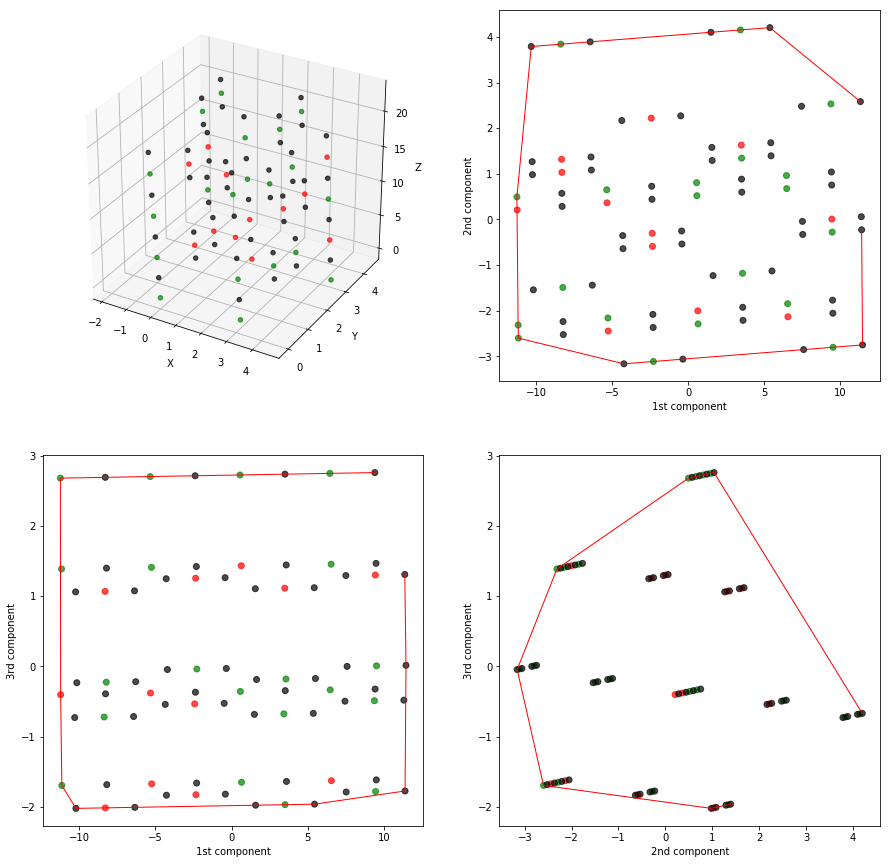

In [34]:
mat1 = GeometryPCA('data/train', '2', plotFlag=True)

### Correlations

In [66]:
#Correlations between features
corrFeat = dfTrain[features].corr()
dataCorrFeat = [go.Heatmap(x = features, y = features, z = corrFeat.values,
                          zmin = -1, zmax = 1, showscale = True)]
layout = dict(title = 'Feature-Feature Correlation',
             xaxis = dict(title = 'Features', titlefont = dict(size = 18),
                          showticklabels = False, ticks = ""),
              yaxis = dict(title = 'Features', titlefont = dict(size = 18),
                          showticklabels = False, ticks = ""),
              width = 750, height = 750,
              autosize = False
              )
figure = dict(data = dataCorrFeat, layout = layout)
iplot(figure)

Conclusions: <br />
    - lattice_angle_beta_degree highly correlated with lattice_vector_1_ang.  Plot both together and combine as new feature?
    - number of atoms correlated with larger lattice vectors - self-explanatory.
    - space group correlated with larger lattice_vector_3_ang.  Any way to use this?

In [67]:
#Correlations between features and targets
corrAll = dfTrain[features + targets].corr()
dataCorrAll = [go.Heatmap(x = features, y = targets, z = corrAll.loc[targets, features].values,
                          zmin = -1, zmax = 1, showscale = True)]
layout = dict(title = 'Feature-Target Correlation',
              xaxis = dict(title = 'Features', titlefont = dict(size = 18),
                           showticklabels = False, ticks = ""),
              yaxis = dict(title = 'Targets', titlefont = dict(size = 18),
                           showticklabels = False, ticks = ""),
              width = 800, height = 250,
              autosize = False
              )
figure = dict(data = dataCorrAll, layout = layout)
iplot(figure)

### Exploratory plotting to determine relationships with targets

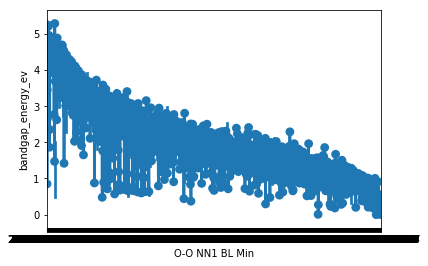

In [68]:
sns.pointplot(dfTrain['O-O NN1 BL Min'], dfTrain['bandgap_energy_ev'])

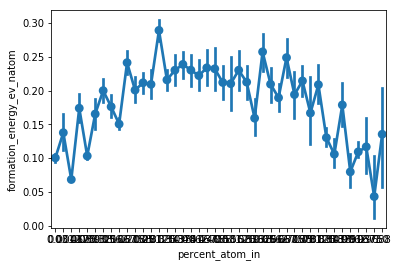

In [69]:
sns.pointplot(dfTrain['percent_atom_in'], dfTrain['formation_energy_ev_natom'])

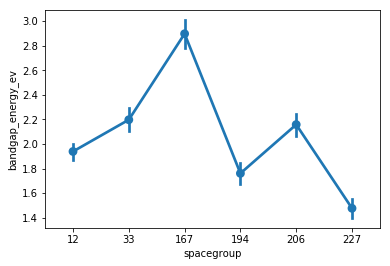

In [70]:
sns.pointplot(dfTrain['spacegroup'], dfTrain['bandgap_energy_ev'])

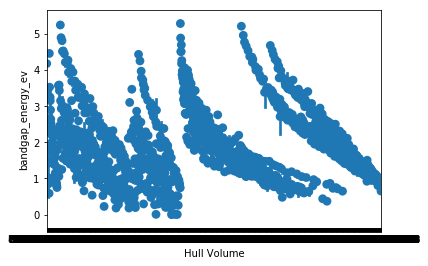

In [71]:
sns.pointplot(dfTrain['Hull Volume'], dfTrain['bandgap_energy_ev'], linestyles='')

Very interesting relationships between Hull Volume and band gap within subset ranges of feature.  Need to do handmade feature engineering to capture these strong, local relationships

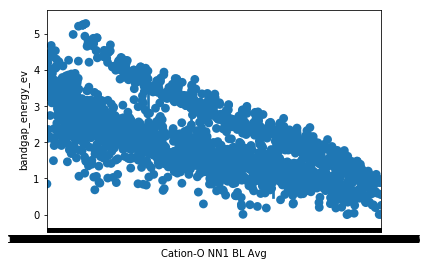

In [72]:
sns.pointplot(dfTrain['Cation-O NN1 BL Avg'], dfTrain['bandgap_energy_ev'], linestyles='')

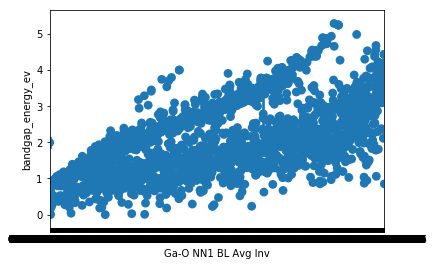

In [73]:
sns.pointplot(dfTrain['Ga-O NN1 BL Avg Inv'], dfTrain['bandgap_energy_ev'], linestyles='')

Ga-O NN1 BL Avg and Cation in general shows two clusters of relationships - need to separate two clustered relationships

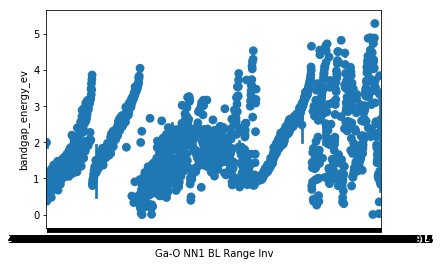

In [74]:
sns.pointplot(dfTrain['Ga-O NN1 BL Range Inv'], dfTrain['bandgap_energy_ev'], linestyles='')

Conclusions: <br />
    - bandgap_energy_ev: most correlated to O-O bond length (min, avg), lower percent_atom_in and higher percent_atom_al - use both in initial model.  Should test polynomial features to get right degree.
    - formation_energy_ev_natom: not as highly correlated, but related to lattice_vector_3, percent_atom_ga, spacegroup
    - Hull Volume, BL ranges, others have interesting relationships with band gap for subset ranges - need to engineer by hand.

## Training and Testing Choice and Scaling and PCA

In [75]:
modelFeatures = features

In [76]:
#--Set features to use
train = dfTrain[modelFeatures]
test = dfTest[modelFeatures]
target = dfTrain[targets]

In [77]:
#--Scale features
scalerStd = StandardScaler(with_mean=True, with_std=True)
scalerMM = MinMaxScaler(feature_range=(0,1))
#Apply scalers to train/test features and targets
trainStd = pd.DataFrame(scalerStd.fit_transform(train), columns=modelFeatures)
trainMM = pd.DataFrame(scalerMM.fit_transform(train), columns=modelFeatures)
targetStd = pd.DataFrame(scalerStd.fit_transform(target), columns=targets)
targetMM = pd.DataFrame(scalerMM.fit_transform(target), columns=targets)
testStd = pd.DataFrame(scalerStd.fit_transform(test), columns=modelFeatures)
testMM = pd.DataFrame(scalerMM.fit_transform(test), columns=modelFeatures)

In [78]:
#--PCA to uncorrelate features if necessary
trainStdPCA = PCA().fit_transform(trainStd)
trainMMPCA = PCA().fit_transform(trainMM)
testStdPCA = PCA().fit_transform(testStd)
testMMPCA = PCA().fit_transform(testMM)

### Linear Regression

This is just a starting point to see what error we get with a basic polynomial regression and few features

In [79]:
#--Cross-Validation to determine optimal polynomial - should use GridSearchCV next to use differen poly for each var
linFeatures = ['percent_atom_al', 'percent_atom_in', 'percent_atom_ga',
               'spacegroup',
               'lattice_vector_3_ang']
polys = 3
print("CV Results:")
print("-----------")
for poly in range(0,polys+1):
    # Create polynomial features
    pf = PolynomialFeatures(degree = poly)
    train_pf = pf.fit_transform(train[linFeatures])
    
    # Create linear regression object
    lr = LinearRegression(normalize = False)
    
    # Set up shuffle split for cross validation
    ss = ShuffleSplit(n_splits = 10, test_size = 0.20)
    
    # Perform cross-validation - take sqrt of MSLE for RMSLE as indicated in competition
    cvBG0 = np.sqrt(cross_val_score(lr, train_pf, target['bandgap_energy_ev'],
                                    scoring = make_scorer(metrics.mean_squared_log_error),
                                    cv = ss))
    
    cvFE0 = np.sqrt(cross_val_score(lr, train_pf, target['formation_energy_ev_natom'],
                                    scoring = make_scorer(metrics.mean_squared_log_error),
                                    cv = ss))
    
    avgBG0 = np.average(cvBG0)
    avgFE0 = np.average(cvFE0)
    avgFinal0 = 0.5 * (avgBG0 + avgFE0)

    print("Poly = %.0i, BG RMSLE = %.3f, FE RMSLE = %.3f, Final RMSLE = %.3f" % (poly, avgBG0, avgFE0, avgFinal0))    

CV Results:
-----------
Poly = 0, BG RMSLE = 0.339, FE RMSLE = 0.086, Final RMSLE = 0.213
Poly = 1, BG RMSLE = 0.190, FE RMSLE = 0.070, Final RMSLE = 0.130
Poly = 2, BG RMSLE = 0.101, FE RMSLE = 0.042, Final RMSLE = 0.072
Poly = 3, BG RMSLE = 0.089, FE RMSLE = 0.035, Final RMSLE = 0.062


Conclusions: <br />
    - key variables to include are: percents of all atoms except Ga that doesn't matter (helps BG), percentGa and spacegroup and z-d listLattice vector (helps FE)
    - 3rd degree polynomial enough

In [81]:
#--LR: Final fitting and prediction

pf = PolynomialFeatures(degree = 3)
train_pf = pf.fit_transform(train[linFeatures])
test_pf = pf.fit_transform(dfTest[linFeatures])
lr = LinearRegression(normalize = False)

# BG fitting and prediction
lr.fit(train_pf, target['bandgap_energy_ev'])
predBG = lr.predict(test_pf)

# FE fitting and prediction
lr.fit(train_pf, target['formation_energy_ev_natom'])
predFE = lr.predict(test_pf)

In [82]:
#--LR: Create submission and save to csv
dfSubmit = pd.DataFrame(columns = ['formation_energy_ev_natom', 'bandgap_energy_ev'], index = dfTest['id'])
dfSubmit['formation_energy_ev_natom'] = predFE
dfSubmit['bandgap_energy_ev'] = predBG
dfSubmit.to_csv('lr_nomad_12272017.csv')

## SVM

Turns out that using higher C values, even if giving better test scores in GridSearch, still lead to overfitting and high variance when submitting to Kaggle!  C = 1 seems to be best so far - not sure I understand why!!
All Feature Notes: <br />
    - Set CN NaN values to 0, remove rest - this makes sense physically, as 0 has meaning (no coordination)
        - tranStd optimal: BG=0.088 for C = 1, eps = 0.01, 0.015 training discrepancy;
                           FE = 0.028 for C = 1, eps = 0.01
        - tranMM optimal: BG = 0.082 for C = 100, eps = 0.01
                           FE = 0.028 for C = 100, eps = 0.01
        
    - When including NaN = 0 and all features: much bigger difference between training and test scores - training are awesome!  Lots of variance b/c test scores higher
        - Need to figure out reason for overfitting - would a boost help?
        - With NaN = 0, BG testing scores much worse (much more variance) , not helped by Bagging, so need to use NaN removed for now
    - When excluding NaN and using all features:
        - trainStd optimal :kernel = rbf, C = 1, eps = 0.01 has gotten FE down to 0.031 average (better than reg), but BG still around 0.087
        - tranMM optimal: kernel = rbf, C = 1000, eps = 0.01 has gotten FE down to 0.033, BG = 0.085

In [83]:
#Set parameter space for GridSearchCV
kernelsBG = ['rbf']
CBG = [1]
epsBG = [0.01]
svrParamBG = {'kernel':kernelsBG, 'C':CBG, 'epsilon':epsBG}
ss = ShuffleSplit(n_splits = 20, test_size = 0.20)

In [84]:
#Band gap SVR GridSearch results
svrBG = SVR()
svrGsBG = GridSearchCV(svrBG, svrParamBG, cv = ss,
                       scoring=metrics.make_scorer(mean_squared_log_error_JT),
                       return_train_score=True)
svrGsBG.fit(trainStd, target['bandgap_energy_ev'])
svrGsBG.cv_results_

{'mean_fit_time': array([ 0.55217119]),
 'mean_score_time': array([ 0.1019281]),
 'mean_test_score': array([ 0.08918399]),
 'mean_train_score': array([ 0.07074746]),
 'param_C': masked_array(data = [1],
              mask = [False],
        fill_value = ?),
 'param_epsilon': masked_array(data = [0.01],
              mask = [False],
        fill_value = ?),
 'param_kernel': masked_array(data = ['rbf'],
              mask = [False],
        fill_value = ?),
 'params': [{'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'}],
 'rank_test_score': array([1]),
 'split0_test_score': array([ 0.1004572]),
 'split0_train_score': array([ 0.06681588]),
 'split10_test_score': array([ 0.08255889]),
 'split10_train_score': array([ 0.07039673]),
 'split11_test_score': array([ 0.0887383]),
 'split11_train_score': array([ 0.07073602]),
 'split12_test_score': array([ 0.09000136]),
 'split12_train_score': array([ 0.06929452]),
 'split13_test_score': array([ 0.08245981]),
 'split13_train_score': array([ 0.07237139]),


In [85]:
#Set parameter space for GridSearchCV
kernelsFE = ['rbf']
CFE = [1]
epsFE = [0.01]
svrParamFE = {'kernel':kernelsFE, 'C':CFE, 'epsilon':epsFE}
ss = ShuffleSplit(n_splits = 20, test_size = 0.20)

In [86]:
#Formation energy SVR GridSearch results
svrFE = SVR()
svrGsFE = GridSearchCV(svrFE, svrParamFE, cv = ss,
                     scoring=metrics.make_scorer(mean_squared_log_error_JT),
                     return_train_score=True)
svrGsFE.fit(trainStd, target['formation_energy_ev_natom'])
svrGsFE.cv_results_

{'mean_fit_time': array([ 0.39517602]),
 'mean_score_time': array([ 0.06464143]),
 'mean_test_score': array([ 0.0286741]),
 'mean_train_score': array([ 0.01894331]),
 'param_C': masked_array(data = [1],
              mask = [False],
        fill_value = ?),
 'param_epsilon': masked_array(data = [0.01],
              mask = [False],
        fill_value = ?),
 'param_kernel': masked_array(data = ['rbf'],
              mask = [False],
        fill_value = ?),
 'params': [{'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'}],
 'rank_test_score': array([1]),
 'split0_test_score': array([ 0.03102513]),
 'split0_train_score': array([ 0.01885245]),
 'split10_test_score': array([ 0.02663221]),
 'split10_train_score': array([ 0.01866242]),
 'split11_test_score': array([ 0.02968348]),
 'split11_train_score': array([ 0.01930521]),
 'split12_test_score': array([ 0.02661485]),
 'split12_train_score': array([ 0.01904109]),
 'split13_test_score': array([ 0.02889923]),
 'split13_train_score': array([ 0.01928313])

In [87]:
#--SVM: Final fitting and prediction
# BG fitting and prediction
svrBG = SVR(kernel='rbf', C=1, epsilon=0.01)
svrBG.fit(trainStd, target['bandgap_energy_ev'])
predSvrBG = svrBG.predict(testStd)

# FE fitting and prediction
svrFE = SVR(kernel='rbf', C=1, epsilon=0.01)
svrFE.fit(trainStd, target['formation_energy_ev_natom'])
predSvrFE = svrFE.predict(testStd)

In [88]:
#--SVM: Create submission and save to csv
dfSubmitSVR = pd.DataFrame(columns = ['formation_energy_ev_natom', 'bandgap_energy_ev'], index = dfTest['id'])
dfSubmitSVR['formation_energy_ev_natom'] = predSvrFE
dfSubmitSVR['bandgap_energy_ev'] = predSvrBG
dfSubmitSVR.to_csv('svr_nomad_Std_01152018.csv')

## Bagging Testing

### BaggingRegressor

Best Yet: <br />
    - BG: Bagging doesn't help!
        - 0.088 - BR: n_estimators: 25, max_features = 30, max_samples = 1.0, SVR: C = 1, eps = 0.01
    - FE: try to reduce variance by increasing n_est and decreasing max_samples, max_features, allows for higher C to fit better - bias-variance tradeoff
        - 0.025 - BR: n_estimators: 75, max_features = 30, max_samples = 0.5, SVR: C = 100, eps = 0.01
        - 0.029 - BR: n_estimators: 50, max_features = 40, max_samples = 1.0, SVR: C = 1, eps = 0.01
        - 0.028 - BR: n_estimators = 25, max_features = 30, max_samples = 0.5, SVR: C = 10, eps = 0.01

In [89]:
# With SVR estimator
svr_for_BR = SVR(kernel='rbf', C=1, epsilon=0.01)
BRsvrBG = BaggingRegressor(base_estimator=svr_for_BR, n_estimators = 25, max_features=0.5, max_samples=0.5,
                          bootstrap=True, bootstrap_features=True)
ss = ShuffleSplit(n_splits = 20, test_size = 0.20)

In [90]:
numEst = [25, 300]
maxFeat = [0.25]
maxSamp = [0.25]
BRsvrBG_param = {'n_estimators':numEst, 'max_features':maxFeat, 'max_samples':maxSamp}
BRsvrBG_gs = GridSearchCV(BRsvrBG, BRsvrBG_param, cv = ss,
                     scoring=metrics.make_scorer(mean_squared_log_error_JT),
                     return_train_score=True)
BRsvrBG_gs.fit(trainStd, target['bandgap_energy_ev'])
BRsvrBG_gs.cv_results_

{'mean_fit_time': array([ 0.41830516,  4.82187666]),
 'mean_score_time': array([ 0.19541011,  2.28628139]),
 'mean_test_score': array([ 0.10200465,  0.1023444 ]),
 'mean_train_score': array([ 0.09817647,  0.09823274]),
 'param_max_features': masked_array(data = [0.25 0.25],
              mask = [False False],
        fill_value = ?),
 'param_max_samples': masked_array(data = [0.25 0.25],
              mask = [False False],
        fill_value = ?),
 'param_n_estimators': masked_array(data = [25 300],
              mask = [False False],
        fill_value = ?),
 'params': [{'max_features': 0.25, 'max_samples': 0.25, 'n_estimators': 25},
  {'max_features': 0.25, 'max_samples': 0.25, 'n_estimators': 300}],
 'rank_test_score': array([2, 1]),
 'split0_test_score': array([ 0.1009886 ,  0.09908813]),
 'split0_train_score': array([ 0.10000314,  0.09913064]),
 'split10_test_score': array([ 0.11096127,  0.11442738]),
 'split10_train_score': array([ 0.09419033,  0.09657353]),
 'split11_test_score'

In [91]:
# With SVR estimator
svr_for_BR = SVR(kernel='rbf', C=100, epsilon=0.01)
BRsvrFE = BaggingRegressor(base_estimator=svr_for_BR, n_estimators = 25, max_features=0.5, max_samples=0.5,
                          bootstrap=True, bootstrap_features=True)
ss = ShuffleSplit(n_splits = 3, test_size = 0.20)

In [92]:
numEst = [75]
maxFeat = [0.25]
maxSamp = [0.5]
BRsvrFE_param = {'n_estimators':numEst, 'max_features':maxFeat, 'max_samples':maxSamp}
BRsvrFE_gs = GridSearchCV(BRsvrFE, BRsvrFE_param, cv = ss,
                     scoring=metrics.make_scorer(mean_squared_log_error_JT),
                     return_train_score=True)
BRsvrFE_gs.fit(trainStd, target['formation_energy_ev_natom'])
BRsvrFE_gs.cv_results_

{'mean_fit_time': array([ 22.16163516]),
 'mean_score_time': array([ 0.7530206]),
 'mean_test_score': array([ 0.02749705]),
 'mean_train_score': array([ 0.01950192]),
 'param_max_features': masked_array(data = [0.25],
              mask = [False],
        fill_value = ?),
 'param_max_samples': masked_array(data = [0.5],
              mask = [False],
        fill_value = ?),
 'param_n_estimators': masked_array(data = [75],
              mask = [False],
        fill_value = ?),
 'params': [{'max_features': 0.25, 'max_samples': 0.5, 'n_estimators': 75}],
 'rank_test_score': array([1]),
 'split0_test_score': array([ 0.02495631]),
 'split0_train_score': array([ 0.02027724]),
 'split1_test_score': array([ 0.02704256]),
 'split1_train_score': array([ 0.01946277]),
 'split2_test_score': array([ 0.03049226]),
 'split2_train_score': array([ 0.01876574]),
 'std_fit_time': array([ 0.24107572]),
 'std_score_time': array([ 0.02352702]),
 'std_test_score': array([ 0.00228278]),
 'std_train_score': ar

In [195]:
#--Bagging Regressor with SVM: Final fitting and prediction
# Bagging for BG fitting and prediction
svrBG = SVR(kernel='rbf', C=1, epsilon=0.01)
BRsvrBG = BaggingRegressor(base_estimator=svrBG, n_estimators = 25, max_features=30, max_samples=1.0,
                          bootstrap=True, bootstrap_features=True)
BRsvrBG.fit(trainStd, target['bandgap_energy_ev'])
predBRsvrBG = BRsvrBG.predict(testStd)

# Bagging for FE fitting and prediction
svrFE = SVR(kernel='rbf', C=100, epsilon=0.01)
BRsvrFE = BaggingRegressor(base_estimator=svrFE, n_estimators = 75, max_features=30, max_samples=0.5,
                          bootstrap=True, bootstrap_features=True)
BRsvrFE.fit(trainStd, target['formation_energy_ev_natom'])
predBRsvrFE = BRsvrFE.predict(testStd)

In [196]:
#--SVM: Create submission and save to csv
dfSubmitSVR = pd.DataFrame(columns = ['formation_energy_ev_natom', 'bandgap_energy_ev'], index = dfTest['id'])
dfSubmitSVR['formation_energy_ev_natom'] = predBRsvrFE
dfSubmitSVR['bandgap_energy_ev'] = predBRsvrBG
dfSubmitSVR.to_csv('svr_nomad_Bagging_01062018.csv')

### Random Forest

Rule of Thumb for optimizing RF: <br />
    - start with around 300 trees, 2 min_sample_split to determine splitting stop, then tune number of features used for each (max_feat)
    - from there, tune min_sample_split
    - then, tune number of trees (numEst)
Best so far:
    - BG = 0.0863 : numEst = 2000, min_sample_split = 4, min_sample_leaf = 1, max_features = 0.1
    - FE = 0.0275: numEst = 2000, min_sample_split = 2, min_sample_leaf = 1, max_features = 0.3
Other Notes:
    - Tried using PCA of features - first 10 capture 90% of variance, but when I use this the results are worse (~0.097) than using all features (~0.087) - why??

In [46]:
rf = RandomForestRegressor(n_estimators = 25,
                           criterion = 'mse',
                           max_depth=None, min_samples_split=2, min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, max_features='auto',
                           max_leaf_nodes=None, bootstrap=True)
ss = ShuffleSplit(n_splits = 20, test_size = 0.20)

In [47]:
#Hyperparameters
numEst = [300]
smpl_split = [4]
smpl_leaf = [1]
max_feat = [0.1]
leaf_nodes = [None] #don't use in general
max_depth = [None] #don't use in general - min_samples_split gets at same idea

#Training data
trainingBG = trainStd

rfBG_param = {'n_estimators':numEst, 'max_depth':max_depth, 'min_samples_split':smpl_split, 'min_samples_leaf':smpl_leaf,
                 'max_features':max_feat, 'max_leaf_nodes':leaf_nodes}
rfBG_gs = GridSearchCV(rf, rfBG_param, cv = ss,
                     scoring=metrics.make_scorer(mean_squared_log_error_JT),
                     return_train_score=True)
rfBG_gs.fit(trainingBG, target['bandgap_energy_ev'])
rfBG_gs.cv_results_

{'mean_fit_time': array([ 0.53892798]),
 'mean_score_time': array([ 0.02982693]),
 'mean_test_score': array([ 0.09316917]),
 'mean_train_score': array([ 0.05648898]),
 'param_max_depth': masked_array(data = [None],
              mask = [False],
        fill_value = ?),
 'param_max_features': masked_array(data = [0.1],
              mask = [False],
        fill_value = ?),
 'param_max_leaf_nodes': masked_array(data = [None],
              mask = [False],
        fill_value = ?),
 'param_min_samples_leaf': masked_array(data = [1],
              mask = [False],
        fill_value = ?),
 'param_min_samples_split': masked_array(data = [4],
              mask = [False],
        fill_value = ?),
 'param_n_estimators': masked_array(data = [300],
              mask = [False],
        fill_value = ?),
 'params': [{'max_depth': None,
   'max_features': 0.1,
   'max_leaf_nodes': None,
   'min_samples_leaf': 1,
   'min_samples_split': 4,
   'n_estimators': 300}],
 'rank_test_score': array([1]),
 's

In [48]:
rf = RandomForestRegressor(n_estimators = 25,
                           criterion = 'mse',
                           max_depth=None, min_samples_split=2, min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, max_features='auto',
                           max_leaf_nodes=None, bootstrap=True)
ss = ShuffleSplit(n_splits = 25, test_size = 0.20)

In [49]:
#Hyperparameters
numEst = [300]
smpl_split = [2]
smpl_leaf = [1]
max_feat = [0.9]
leaf_nodes = [None] #don't use in general
max_depth = [None] #don't use in general - min_samples_split gets at same idea

#Training data
#trainingFE = trainStdPCA[:,0:10]
trainingFE= trainStd

rfFE_param = {'n_estimators':numEst, 'max_depth':max_depth, 'min_samples_split':smpl_split, 'min_samples_leaf':smpl_leaf,
                 'max_features':max_feat, 'max_leaf_nodes':leaf_nodes}
rfFE_gs = GridSearchCV(rf, rfFE_param, cv = ss,
                     scoring=metrics.make_scorer(mean_squared_log_error_JT),
                     return_train_score=True)
rfFE_gs.fit(trainingFE, target['formation_energy_ev_natom'])
rfFE_gs.cv_results_

{'mean_fit_time': array([ 2.28247578]),
 'mean_score_time': array([ 0.03324944]),
 'mean_test_score': array([ 0.03551062]),
 'mean_train_score': array([ 0.01972675]),
 'param_max_depth': masked_array(data = [None],
              mask = [False],
        fill_value = ?),
 'param_max_features': masked_array(data = [0.9],
              mask = [False],
        fill_value = ?),
 'param_max_leaf_nodes': masked_array(data = [None],
              mask = [False],
        fill_value = ?),
 'param_min_samples_leaf': masked_array(data = [1],
              mask = [False],
        fill_value = ?),
 'param_min_samples_split': masked_array(data = [2],
              mask = [False],
        fill_value = ?),
 'param_n_estimators': masked_array(data = [300],
              mask = [False],
        fill_value = ?),
 'params': [{'max_depth': None,
   'max_features': 0.9,
   'max_leaf_nodes': None,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 300}],
 'rank_test_score': array([1]),
 's

#### Check out where error is worst

BG: Error occuring for very low band gap, and then between 1-2 eV - need to improve this end of spectrum. <br />
FE: Some outliers at very high formation energy, need to address that.

1
0.0921155473017


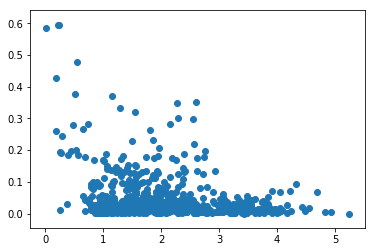

In [112]:
rfFinal = RandomForestRegressor(n_estimators = 300,
                           criterion = 'mse',
                           max_depth=None, min_samples_split=2, min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, max_features=0.5,
                           max_leaf_nodes=None, bootstrap=True)
trainBG, testBG, trainBGout, testBGout = train_test_split(trainingBG, target['bandgap_energy_ev'])
rfFinal.fit(trainBG, trainBGout)
BGpred = rfFinal.predict(testBG)
seriesError = np.sqrt(np.power((np.log(BGpred+1) - np.log(testBGout+1)),2))
dfPlotError = pd.DataFrame(columns=['BG Error'])
dfPlotError['BG Error'] = seriesError
dfPlotError['Band Gap'] = testBGout
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(dfPlotError['Band Gap'], dfPlotError['BG Error'])
print(np.argmax(rfFinal.feature_importances_))
print(mean_squared_log_error_JT(BGpred, testBGout))

[ 0.05865881  0.11666163  0.05154034  0.27312747  0.10432752  0.09602401
  0.07711025  0.22254996]
0.0296500332465


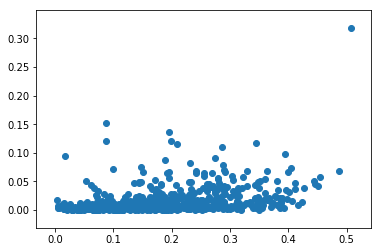

In [113]:
rfFinal = RandomForestRegressor(n_estimators = 10000,
                           criterion = 'mse',
                           max_depth=None, min_samples_split=2, min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, max_features=0.5,
                           max_leaf_nodes=None, bootstrap=True)
trainFE, testFE, trainFEout, testFEout = train_test_split(trainingFE, target['formation_energy_ev_natom'])
rfFinal.fit(trainFE, trainFEout)
FEpred = rfFinal.predict(testFE)
seriesError = np.sqrt(np.power((np.log(FEpred+1) - np.log(testFEout+1)),2))
dfPlotError = pd.DataFrame(columns=['FE Error'])
dfPlotError['FE Error'] = seriesError
dfPlotError['Formation Energy'] = testFEout
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(dfPlotError['Formation Energy'], dfPlotError['FE Error'])
print(rfFinal.feature_importances_)
print(mean_squared_log_error_JT(FEpred, testFEout))

In [220]:
#--Random Forests: Final fitting and prediction
# RF for BG fitting and prediction
rfBG = RandomForestRegressor(n_estimators = 2000, criterion = 'mse', max_depth=None, min_samples_split=4,
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=0.1,
                             max_leaf_nodes=None, bootstrap=True)
rfBG.fit(trainStd, target['bandgap_energy_ev'])
predrfBG = rfBG.predict(testStd)

# RF for FE fitting and prediction
rfFE = RandomForestRegressor(n_estimators = 2000, criterion = 'mse', max_depth=None, min_samples_split=2,
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=0.3,
                             max_leaf_nodes=None, bootstrap=True)
rfFE.fit(trainStd, target['formation_energy_ev_natom'])
predrfFE = rfFE.predict(testStd)

In [221]:
#--RF: Create submission and save to csv
dfSubmitRF = pd.DataFrame(columns = ['formation_energy_ev_natom', 'bandgap_energy_ev'], index = dfTest['id'])
dfSubmitRF['formation_energy_ev_natom'] = predrfFE
dfSubmitRF['bandgap_energy_ev'] = predrfBG
dfSubmitRF.to_csv('rf_nomad_RF_01132018.csv')

## Adaboost

### SVM

In [187]:
# BG With SVR estimator
svr_for_AB = SVR(kernel='rbf', C=1, epsilon=0.01)
ABsvrBG = AdaBoostRegressor(base_estimator=svr_for_AB, n_estimators = 50, learning_rate=1.0, loss='linear')
ss = ShuffleSplit(n_splits = 3, test_size = 0.20)

In [188]:
numEst = [50]
learnRate = [1.0]
loss = ['linear']
ABsvrBG_param = {'n_estimators':numEst, 'learning_rate':learnRate, 'loss':loss}
ABsvrBG_gs = GridSearchCV(ABsvrBG, ABsvrBG_param, cv = ss,
                     scoring=metrics.make_scorer(mean_squared_log_error_JT),
                     return_train_score=True)
ABsvrBG_gs.fit(trainStd, target['bandgap_energy_ev'])
ABsvrBG_gs.cv_results_

{'mean_fit_time': array([ 44.51759291]),
 'mean_score_time': array([ 5.03320734]),
 'mean_test_score': array([ 0.09757036]),
 'mean_train_score': array([ 0.07098099]),
 'param_learning_rate': masked_array(data = [1.0],
              mask = [False],
        fill_value = ?),
 'param_loss': masked_array(data = ['linear'],
              mask = [False],
        fill_value = ?),
 'param_n_estimators': masked_array(data = [50],
              mask = [False],
        fill_value = ?),
 'params': [{'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 50}],
 'rank_test_score': array([1]),
 'split0_test_score': array([ 0.10488992]),
 'split0_train_score': array([ 0.06275128]),
 'split1_test_score': array([ 0.09132593]),
 'split1_train_score': array([ 0.07401857]),
 'split2_test_score': array([ 0.09649523]),
 'split2_train_score': array([ 0.07617314]),
 'std_fit_time': array([ 0.29349164]),
 'std_score_time': array([ 0.03022287]),
 'std_test_score': array([ 0.00558942]),
 'std_train_score': array

In [125]:
# FE With SVR estimator
svr_for_AB_FE = SVR(kernel='rbf', C=1, epsilon=0.01)
ABsvrFE = AdaBoostRegressor(base_estimator=svr_for_AB_FE, n_estimators = 50, learning_rate=1.0, loss='linear')
ss = ShuffleSplit(n_splits = 3, test_size = 0.20)

In [127]:
numEst = [50]
learnRate = [1.0]
loss = ['linear']
ABsvrFE_param = {'n_estimators':numEst, 'learning_rate':learnRate, 'loss':loss}
ABsvrFE_gs = GridSearchCV(ABsvrFE, ABsvrFE_param, cv = ss,
                     scoring=metrics.make_scorer(mean_squared_log_error_JT),
                     return_train_score=True)
ABsvrFE_gs.fit(trainStd, target['formation_energy_ev_natom'])
ABsvrFE_gs.cv_results_

{'mean_fit_time': array([ 10.04927444]),
 'mean_score_time': array([ 0.7234296]),
 'mean_test_score': array([ 0.04303855]),
 'mean_train_score': array([ 0.03827561]),
 'param_learning_rate': masked_array(data = [1.0],
              mask = [False],
        fill_value = ?),
 'param_loss': masked_array(data = ['linear'],
              mask = [False],
        fill_value = ?),
 'param_n_estimators': masked_array(data = [50],
              mask = [False],
        fill_value = ?),
 'params': [{'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 50}],
 'rank_test_score': array([1]),
 'split0_test_score': array([ 0.04461273]),
 'split0_train_score': array([ 0.04089618]),
 'split1_test_score': array([ 0.05022733]),
 'split1_train_score': array([ 0.04319098]),
 'split2_test_score': array([ 0.03427558]),
 'split2_train_score': array([ 0.03073968]),
 'std_fit_time': array([ 1.84035625]),
 'std_score_time': array([ 0.10286604]),
 'std_test_score': array([ 0.00660672]),
 'std_train_score': array(

### Decision Trees

In [205]:
# BG With DT estimator
dt_for_AB = DecisionTreeRegressor(criterion = 'mse', max_depth=6, min_samples_split=2, min_samples_leaf=1,
                                  min_weight_fraction_leaf=0.0, max_features=None,
                                  max_leaf_nodes=None)
ABdtBG = AdaBoostRegressor(base_estimator=dt_for_AB, n_estimators = 50, learning_rate=1.0, loss='linear')
ss = ShuffleSplit(n_splits = 5, test_size = 0.20)

In [206]:
numEst = [500]
learnRate = [1.0]
loss = ['linear']
ABdtBG_param = {'n_estimators':numEst, 'learning_rate':learnRate, 'loss':loss}
ABdtBG_gs = GridSearchCV(ABdtBG, ABdtBG_param, cv = ss,
                     scoring=metrics.make_scorer(mean_squared_log_error_JT),
                     return_train_score=True)
ABdtBG_gs.fit(trainStd, target['bandgap_energy_ev'])
ABdtBG_gs.cv_results_

{'mean_fit_time': array([  2.44120708,  12.33535767,  19.73766141,   2.19556737,
         11.70652151,  19.26326728]),
 'mean_score_time': array([ 0.00680256,  0.03481779,  0.06035442,  0.0067256 ,  0.0341886 ,
         0.05868082]),
 'mean_test_score': array([ 0.09260771,  0.09147766,  0.09095433,  0.09200494,  0.09130271,
         0.09008886]),
 'mean_train_score': array([ 0.05319192,  0.04781895,  0.04723845,  0.05109306,  0.04737546,
         0.04687887]),
 'param_learning_rate': masked_array(data = [0.5 0.5 0.5 1.0 1.0 1.0],
              mask = [False False False False False False],
        fill_value = ?),
 'param_loss': masked_array(data = ['linear' 'linear' 'linear' 'linear' 'linear' 'linear'],
              mask = [False False False False False False],
        fill_value = ?),
 'param_n_estimators': masked_array(data = [50 300 500 50 300 500],
              mask = [False False False False False False],
        fill_value = ?),
 'params': [{'learning_rate': 0.5, 'loss': 'linea

In [191]:
# FE With DT estimator
dt_for_AB_FE = DecisionTreeRegressor(criterion = 'mse', max_depth=4, min_samples_split=2, min_samples_leaf=1,
                                  min_weight_fraction_leaf=0.0, max_features=None,
                                  max_leaf_nodes=None)
ABdtFE = AdaBoostRegressor(base_estimator=dt_for_AB_FE, n_estimators = 50, learning_rate=1.0, loss='linear')
ss = ShuffleSplit(n_splits = 25, test_size = 0.20)

In [192]:
numEst = [50]
learnRate = [0.1, 0.5, 1.0]
loss = ['linear']
ABdtFE_param = {'n_estimators':numEst, 'learning_rate':learnRate, 'loss':loss}
ABdtFE_gs = GridSearchCV(ABdtFE, ABdtFE_param, cv = ss,
                     scoring=metrics.make_scorer(mean_squared_log_error_JT),
                     return_train_score=True)
ABdtFE_gs.fit(trainStd, target['bandgap_energy_ev'])
ABdtFE_gs.cv_results_

{'mean_fit_time': array([ 4.22775594]),
 'mean_score_time': array([ 0.01041826]),
 'mean_test_score': array([ 0.09340346]),
 'mean_train_score': array([ 0.00481749]),
 'param_learning_rate': masked_array(data = [1.0],
              mask = [False],
        fill_value = ?),
 'param_loss': masked_array(data = ['linear'],
              mask = [False],
        fill_value = ?),
 'param_n_estimators': masked_array(data = [50],
              mask = [False],
        fill_value = ?),
 'params': [{'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 50}],
 'rank_test_score': array([1]),
 'split0_test_score': array([ 0.09501847]),
 'split0_train_score': array([ 0.00495054]),
 'split1_test_score': array([ 0.08566047]),
 'split1_train_score': array([ 0.00488781]),
 'split2_test_score': array([ 0.09953145]),
 'split2_train_score': array([ 0.00461412]),
 'std_fit_time': array([ 0.14061752]),
 'std_score_time': array([ 0.00215552]),
 'std_test_score': array([ 0.0057768]),
 'std_train_score': array([

## Light Gradient Boosting (lgboost package)

In [94]:
#Specific evaluation function of lgboost package
def mean_squared_log_error_JT_LGB(ground_truth, predictions):
    '''
    eval metric for lgb
    '''
    diff = np.power((np.log(predictions+1) - np.log(ground_truth+1)),2)
    return 'RMSLE', np.sqrt(np.average(diff)), False

In [95]:
#One validation set to test lgboost package
X_train = train.tail(2200)
X_val = train.head(200)

target_train = target.tail(2200)
target_val = target.head(200)

y_train_1 = target_train['bandgap_energy_ev']
y_train_2 = target_train["formation_energy_ev_natom"]

y_val_1 = target_val['bandgap_energy_ev']
y_val_2 = target_val["formation_energy_ev_natom"]

In [96]:
params = {
    'num_leaves': 7,
    'objective': 'regression',
    'min_data_in_leaf': 20,
    'learning_rate': 0.05,
    'feature_fraction': 0.93,
    'bagging_fraction': 0.93,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 4
}

MAX_ROUNDS = 1400
val_pred = []
test_pred_1 = []
cate_vars = []

dtrain = lgb.Dataset(X_train, label=y_train_1,categorical_feature=cate_vars)

dval = lgb.Dataset(X_val, label=y_val_1, reference=dtrain,categorical_feature=cate_vars)

bst = lgb.train(params, dtrain, num_boost_round=MAX_ROUNDS,valid_sets=[dtrain, dval], early_stopping_rounds=50, verbose_eval=100)

print("\n".join(("%s: %.2f" % x) for x in sorted(zip(X_train.columns, bst.feature_importance("gain")),key=lambda x: x[1], reverse=True)))

val_pred.append(bst.predict(X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))

test_pred_1.append(bst.predict(test, num_iteration=bst.best_iteration or MAX_ROUNDS))

C:\Users\Jonathan\Anaconda3\lib\site-packages\lightgbm\basic.py:1027: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 50 rounds.
[100]	training's l2: 0.0347428	valid_1's l2: 0.0585081
[200]	training's l2: 0.0224899	valid_1's l2: 0.0496015
[300]	training's l2: 0.0168595	valid_1's l2: 0.0480937
Early stopping, best iteration is:
[298]	training's l2: 0.0169519	valid_1's l2: 0.048034
O-O NN1 BL Min Inv: 11597.66
O-O NN1 BL Min: 3776.56
Cation-O NN1 BL Max: 873.96
O-Al NN1 BL Avg Inv: 501.27
Al-Al NN1 BL Avg Inv: 423.39
O-Al NN1 BL Max Inv: 377.13
percent_atom_in: 316.11
Al-O NN1 BL Max Inv: 229.57
Al-Al NN1 BL Min Inv: 226.76
zy: 213.91
Hull Volume 1-3: 179.58
Al-Al NN1 BL Max Inv: 137.28
lattice_vector_3_ang: 127.99
Cation-O NN1 BL Avg: 116.82
O-Al NN1 BL Range Inv: 105.04
Al Atoms: 103.46
spacegroup: 99.88
percent_atom_al: 99.78
yz: 98.98
O-O NN1 BL Avg: 86.04
Ga-Al NN1 BL Avg Inv: 83.67
Ga-Al NN1 BL Max Inv: 79.49
In-O NN1 BL Avg Inv: 78.67
Hull Volume 1-2: 66.87
In Atoms: 63.11
lattice_angle_alpha_degree: 55.61
In CN Avg: 54.07
Al-O NN1 BL Avg Inv: 53

In [97]:
params = {
    'num_leaves': 7,
    'objective': 'regression',
    'min_data_in_leaf': 20,
    'learning_rate': 0.05,
    'feature_fraction': 0.93,
    'bagging_fraction': 0.93,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 4
}

MAX_ROUNDS = 1400
val_pred = []
test_pred_2 = []
cate_vars = []

dtrain = lgb.Dataset(X_train, label=y_train_2,categorical_feature=cate_vars)

dval = lgb.Dataset(X_val, label=y_val_2, reference=dtrain,categorical_feature=cate_vars)

bst = lgb.train(params, dtrain, num_boost_round=MAX_ROUNDS,valid_sets=[dtrain, dval], early_stopping_rounds=50, verbose_eval=100)

print("\n".join(("%s: %.2f" % x) for x in sorted(zip(X_train.columns, bst.feature_importance("gain")),key=lambda x: x[1], reverse=True)))

val_pred.append(bst.predict(X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))

test_pred_2.append(bst.predict(test, num_iteration=bst.best_iteration or MAX_ROUNDS))

C:\Users\Jonathan\Anaconda3\lib\site-packages\lightgbm\basic.py:1027: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 50 rounds.
[100]	training's l2: 0.00102789	valid_1's l2: 0.00120606
[200]	training's l2: 0.000673643	valid_1's l2: 0.000981305
[300]	training's l2: 0.000512649	valid_1's l2: 0.000891995
[400]	training's l2: 0.000407422	valid_1's l2: 0.000846375
[500]	training's l2: 0.000336953	valid_1's l2: 0.000815009
[600]	training's l2: 0.000284847	valid_1's l2: 0.000791737
[700]	training's l2: 0.000244989	valid_1's l2: 0.000781246
[800]	training's l2: 0.00020923	valid_1's l2: 0.000770605
[900]	training's l2: 0.000182935	valid_1's l2: 0.000761516
[1000]	training's l2: 0.000160786	valid_1's l2: 0.000751868
[1100]	training's l2: 0.00014202	valid_1's l2: 0.000748885
Early stopping, best iteration is:
[1053]	training's l2: 0.000150359	valid_1's l2: 0.000748422
lattice_vector_3_ang: 64.30
Al-In NN1 BL Avg Inv: 24.55
In-O NN1 BL Avg Inv: 11.30
Al-In NN1 BL Min Inv: 9.41
In-O NN1 BL Min Inv: 9.33
Ga-O NN1 BL Avg Inv: 8.08
lattice_angle_alpha_degree: 6.52
I

In [98]:
sample = pd.read_csv("sample_submission.csv")

sample["formation_energy_ev_natom"] = test_pred_2[0]
sample["bandgap_energy_ev"] = test_pred_1[0]

sample.to_csv("lgb_BaseFeatures_1_14_2018.csv",index = False)

## Light GBM in scikit-learn - true cross-validation

Notes:
    - Don't use scaled values for Light GBM - get much worse predictions!  Unless I haven't parametrized well enogh
    - Next steps: put standard CV procedure in place that stil uses early stopping - can't do with sklearn pipeline alone.

In [99]:
cateVar=[]
trainLGB = lgb.Dataset(train, label=target['bandgap_energy_ev'],categorical_feature=cateVar)
params = {'num_leaves': 8,
          'objective': 'regression',
          'min_data_in_leaf': 20,
          'learning_rate': 0.05,
          'feature_fraction': 0.93,
          'bagging_fraction': 0.93,
          'bagging_freq': 1,
          'metric': 'l2',
          'num_threads': 4
         }

In [100]:
#LOOK INTO metrics, fobj, feval to see if i can use mean square log loss as one of these?!
cv_mod = lgb.cv(params, trainLGB, num_boost_round = 1400,
                folds=None, nfold=30, stratified=False, shuffle=True,
                metrics=None, fobj=None, feval=None,
                feature_name='auto', categorical_feature=cateVar,
                early_stopping_rounds=50, verbose_eval=100
                )

[100]	cv_agg's l2: 0.0497444 + 0.01709
[200]	cv_agg's l2: 0.0444439 + 0.0146715
[300]	cv_agg's l2: 0.0430728 + 0.0142585
[400]	cv_agg's l2: 0.0423498 + 0.0143617
[500]	cv_agg's l2: 0.0420297 + 0.0141777
[600]	cv_agg's l2: 0.0417929 + 0.0139345
[700]	cv_agg's l2: 0.041705 + 0.0139213
[800]	cv_agg's l2: 0.0415767 + 0.0137813
[900]	cv_agg's l2: 0.0415834 + 0.0137341


In [101]:
# BG With lgboost estimator
lgb_BG = LGBMRegressor(boosting_type='gbdt', objective='regression',
                       num_leaves=8, max_depth=-1, learning_rate=0.05, n_estimators=1000,
                       subsample_for_bin=50000, class_weight=None,
                       min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20,
                       subsample=0.93, subsample_freq=1, colsample_bytree=1.0,
                       reg_alpha=0.0, reg_lambda=0.0,
                       n_jobs=4, silent=False)
#BG - This is how I can get RMSLE!!
lgb_BG.fit(X_train, y_train_1,
           eval_set=[(X_train, y_train_1), (X_val, y_val_1)],
           eval_metric = mean_squared_log_error_JT_LGB,
           early_stopping_rounds=50, verbose=True)
lgb_BG.feature_importances_

[1]	training's RMSLE: 0.32283	valid_1's RMSLE: 0.300092
Training until validation scores don't improve for 50 rounds.
[2]	training's RMSLE: 0.31031	valid_1's RMSLE: 0.288042
[3]	training's RMSLE: 0.2987	valid_1's RMSLE: 0.276492
[4]	training's RMSLE: 0.287748	valid_1's RMSLE: 0.265751
[5]	training's RMSLE: 0.277422	valid_1's RMSLE: 0.255608
[6]	training's RMSLE: 0.267569	valid_1's RMSLE: 0.246577
[7]	training's RMSLE: 0.258147	valid_1's RMSLE: 0.237985
[8]	training's RMSLE: 0.249373	valid_1's RMSLE: 0.229746
[9]	training's RMSLE: 0.241011	valid_1's RMSLE: 0.222121
[10]	training's RMSLE: 0.233202	valid_1's RMSLE: 0.214654
[11]	training's RMSLE: 0.225508	valid_1's RMSLE: 0.207344
[12]	training's RMSLE: 0.218369	valid_1's RMSLE: 0.200907
[13]	training's RMSLE: 0.211717	valid_1's RMSLE: 0.194911
[14]	training's RMSLE: 0.205278	valid_1's RMSLE: 0.188907
[15]	training's RMSLE: 0.199279	valid_1's RMSLE: 0.18349
[16]	training's RMSLE: 0.193375	valid_1's RMSLE: 0.178157
[17]	training's RMSLE: 0

array([56, 26,  0,  7, 25,  0, 20,  0,  5,  5, 20, 13, 15, 10,  3, 12, 70,
       15,  8,  5, 32, 72, 10,  9, 10,  7, 22,  8, 38,  3, 34, 15, 18, 47,
       29, 13, 16, 49,  7,  5, 33,  4,  5, 19, 25, 10, 42,  3,  0, 15,  0,
       42,  4, 24,  9,  5,  6, 47,  5, 18, 11,  5, 36, 28, 12, 50, 29, 12,
       14,  6, 22,  4, 11, 10, 21, 15, 13, 76, 23,  0, 24, 12, 27,  7,  8,
       19, 29,  9, 29,  9,  5,  7, 35, 30,  7, 32, 21,  6, 11,  9, 13, 21,
        6,  3,  0,  8,  2,  5, 19,  5, 20,  0,  4, 25, 16,  6, 18, 31,  8,
       21, 29, 24,  8,  6, 28])

In [102]:
# FE With lgboost estimator
lgb_FE = LGBMRegressor(boosting_type='gbdt', objective='regression',
                       num_leaves=8, max_depth=-1, learning_rate=0.05, n_estimators=500,
                       subsample_for_bin=50000, class_weight=None,
                       min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20,
                       subsample=0.93, subsample_freq=1, colsample_bytree=1.0,
                       reg_alpha=0.0, reg_lambda=0.0,
                       n_jobs=4, silent=False)
#FE - This is how I can get RMSLE!!
lgb_FE.fit(X_train, y_train_2,
           eval_set=[(X_train, y_train_2), (X_val, y_val_2)],
           eval_metric = mean_squared_log_error_JT_LGB,
           early_stopping_rounds=50, verbose=True)
lgb_FE.feature_importances_

[1]	training's RMSLE: 0.0832812	valid_1's RMSLE: 0.0869561
Training until validation scores don't improve for 50 rounds.
[2]	training's RMSLE: 0.0804686	valid_1's RMSLE: 0.0840783
[3]	training's RMSLE: 0.0777546	valid_1's RMSLE: 0.0813102
[4]	training's RMSLE: 0.0752185	valid_1's RMSLE: 0.0786614
[5]	training's RMSLE: 0.0728909	valid_1's RMSLE: 0.0763661
[6]	training's RMSLE: 0.0705867	valid_1's RMSLE: 0.0739859
[7]	training's RMSLE: 0.068524	valid_1's RMSLE: 0.0718876
[8]	training's RMSLE: 0.0665353	valid_1's RMSLE: 0.069789
[9]	training's RMSLE: 0.0646609	valid_1's RMSLE: 0.0678199
[10]	training's RMSLE: 0.0628889	valid_1's RMSLE: 0.0660012
[11]	training's RMSLE: 0.0611603	valid_1's RMSLE: 0.0640823
[12]	training's RMSLE: 0.0595516	valid_1's RMSLE: 0.062453
[13]	training's RMSLE: 0.0580581	valid_1's RMSLE: 0.0609251
[14]	training's RMSLE: 0.0565944	valid_1's RMSLE: 0.0594247
[15]	training's RMSLE: 0.0552016	valid_1's RMSLE: 0.0579015
[16]	training's RMSLE: 0.0538529	valid_1's RMSLE: 

array([ 23,  18,   1,  38,  33,   1,  23,   0,   0,  16,  41,  14,   8,
        19,  42,  11, 112,  50,  33,   8,  65,  24,  41,  32,  14,  30,
        52,  16,  54,  11,  57,  77,  40,  48,  91,  11,  11,   5,  26,
        13,  40,   7,  57,  34, 142,  36,  26,   3,   0,  13,   1,  25,
        11,  48,  29,  11,  12,  92,  31,  31,  21,  25,  36,  54,  36,
        37,  44,   7,  38,  14,  13,  20,  10,  21,  22,  21,  39,  51,
        29,   0,  45,  46,  33,  25,  15,  25,  99,  35,  25,  21,   1,
         8,  60,  27,  20,  28,  16,  11,  39,  36,  10,  14,  10,  16,
         1,  21,  12,   1,  38,  13,  36,   3,  14,   8,  26,  12,  12,
        31,  37,  33,  43,  27,  11,  18,  42])

In [103]:
# BG Fitting
ss = ShuffleSplit(n_splits = 20, test_size = 0.20)
paramsLGB_BG = {'boosting_type':['gbdt'],
                'num_leaves':[8],
                'max_depth':[-1],
                'learning_rate':[0.05],
                'n_estimators':[300],
                'min_child_samples':[20],
                'min_split_gain':[0.0],
                'min_child_weight':[0.001],
                'subsample':[0.93],
                'subsample_freq':[1],
                'colsample_bytree':[0.93],
                'reg_alpha':[0.0],
                'reg_lambda':[0.0]
                }

#Training data
trainingBG = train

#Fit and CV
lgbBG_gs = GridSearchCV(lgb_BG, paramsLGB_BG, cv = ss,
                     scoring=metrics.make_scorer(mean_squared_log_error_JT),
                     return_train_score=True)
lgbBG_gs.fit(trainingBG, target['bandgap_energy_ev'])
lgbBG_gs.cv_results_

{'mean_fit_time': array([ 0.44836953]),
 'mean_score_time': array([ 0.00845255]),
 'mean_test_score': array([ 0.08281383]),
 'mean_train_score': array([ 0.04806031]),
 'param_boosting_type': masked_array(data = ['gbdt'],
              mask = [False],
        fill_value = ?),
 'param_colsample_bytree': masked_array(data = [0.93],
              mask = [False],
        fill_value = ?),
 'param_learning_rate': masked_array(data = [0.05],
              mask = [False],
        fill_value = ?),
 'param_max_depth': masked_array(data = [-1],
              mask = [False],
        fill_value = ?),
 'param_min_child_samples': masked_array(data = [20],
              mask = [False],
        fill_value = ?),
 'param_min_child_weight': masked_array(data = [0.001],
              mask = [False],
        fill_value = ?),
 'param_min_split_gain': masked_array(data = [0.0],
              mask = [False],
        fill_value = ?),
 'param_n_estimators': masked_array(data = [300],
              mask = [False],

In [104]:
# DW Fitting
ss = ShuffleSplit(n_splits = 20, test_size = 0.20)
paramsLGB_FE = {'boosting_type':['gbdt'],
                'num_leaves':[8],
                'max_depth':[-1],
                'learning_rate':[0.05],
                'n_estimators':[300],
                'min_child_samples':[20],
                'min_split_gain':[0.0],
                'min_child_weight':[0.001],
                'subsample':[0.93],
                'subsample_freq':[1],
                'colsample_bytree':[0.93],
                'reg_alpha':[0.0],
                'reg_lambda':[0.0]
                }

#Training data
trainingFE = train

#Fit and CV
lgbFE_gs = GridSearchCV(lgb_FE, paramsLGB_FE, cv = ss,
                     scoring=metrics.make_scorer(mean_squared_log_error_JT),
                     return_train_score=True)
lgbFE_gs.fit(trainingFE, target['formation_energy_ev_natom'])
lgbFE_gs.cv_results_

{'mean_fit_time': array([ 0.47386136]),
 'mean_score_time': array([ 0.01019529]),
 'mean_test_score': array([ 0.02570987]),
 'mean_train_score': array([ 0.01626826]),
 'param_boosting_type': masked_array(data = ['gbdt'],
              mask = [False],
        fill_value = ?),
 'param_colsample_bytree': masked_array(data = [0.93],
              mask = [False],
        fill_value = ?),
 'param_learning_rate': masked_array(data = [0.05],
              mask = [False],
        fill_value = ?),
 'param_max_depth': masked_array(data = [-1],
              mask = [False],
        fill_value = ?),
 'param_min_child_samples': masked_array(data = [20],
              mask = [False],
        fill_value = ?),
 'param_min_child_weight': masked_array(data = [0.001],
              mask = [False],
        fill_value = ?),
 'param_min_split_gain': masked_array(data = [0.0],
              mask = [False],
        fill_value = ?),
 'param_n_estimators': masked_array(data = [300],
              mask = [False],

In [105]:
# LGBM final fitting
lgb_BG_Final = LGBMRegressor(boosting_type='gbdt', objective='regression',
                       num_leaves=8, max_depth=-1, learning_rate=0.05, n_estimators=300,
                       subsample_for_bin=50000, class_weight=None,
                       min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20,
                       subsample=0.93, subsample_freq=1, colsample_bytree=1.0,
                       reg_alpha=0.0, reg_lambda=0.0,
                       n_jobs=4, silent=False)
lgb_BG_Final.fit(train, target['bandgap_energy_ev'])
predLgbBG = lgb_BG_Final.predict(test)

In [106]:
# LGBM final fitting
lgb_FE_Final = LGBMRegressor(boosting_type='gbdt', objective='regression',
                       num_leaves=8, max_depth=-1, learning_rate=0.05, n_estimators=297,
                       subsample_for_bin=50000, class_weight=None,
                       min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20,
                       subsample=0.93, subsample_freq=1, colsample_bytree=1.0,
                       reg_alpha=0.0, reg_lambda=0.0,
                       n_jobs=4, silent=False)
lgb_FE_Final.fit(train, target['formation_energy_ev_natom'])
predLgbFE = lgb_FE_Final.predict(test)

In [107]:
#--RF: Create submission and save to csv
dfSubmitLGB = pd.DataFrame(columns = ['formation_energy_ev_natom', 'bandgap_energy_ev'], index = dfTest['id'])
dfSubmitLGB['formation_energy_ev_natom'] = predLgbFE
dfSubmitLGB['bandgap_energy_ev'] = predLgbBG
dfSubmitLGB.to_csv('lgb_cv_nomad_AllFeatures_noscale_01152018.csv')